In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

## Record Audio

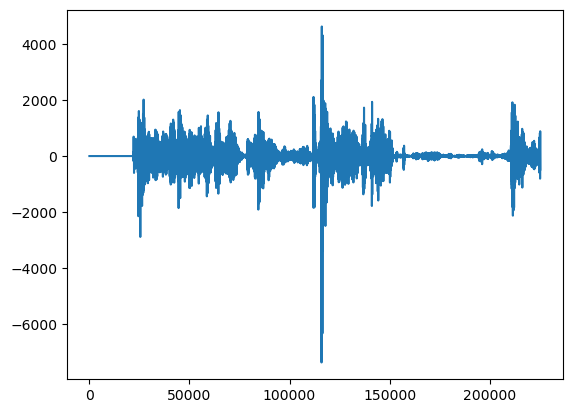

In [15]:
FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ, input=True, frames_per_buffer=FRAMESIZE)
data = stream.read(NOFFRAMES*FRAMESIZE)
decoded = np.frombuffer(data, "int16")

stream.stop_stream()
stream.close()
plt.plot(decoded)
plt.show()